In [122]:
# some python imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

In [123]:
theta_E = 3.2
ra_source = 0.05
dec_source = 0.05

In [124]:
# Data Specifics
background_rms = 7.  # background noise per pixel 
exp_time = 90.  # exposure time 
numPix = 45  # cutout pixel size per axis
deltaPix = 0.2637  # pixel size in arcsec
fwhm = 1 # close to g-band fwhm
psf_type = 'GAUSSIAN'

x_images=[ 2.99339167 -3.2596379  -2.65524769 -0.02337479]
y_images=[ 1.6658746  -0.16161379  1.66276778 -3.04795897]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_39667/1214305787.py:65: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_sim), origin='lower')


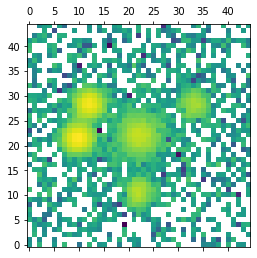

In [125]:
### SIMULATION
## PSF
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

## Lens
# lens model
lens_model_list = ['SIE', 'SHEAR']

kwargs_shear = {'gamma1': 0.05, 'gamma2': 0.05}  
kwargs_sie = {'theta_E': theta_E, 'center_x': 0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05}
kwargs_lens = [kwargs_sie, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# lens light
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 400, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

## Source
# source light
source_model_list = ['SERSIC_ELLIPSE']
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)

print(f'x_images={x_image}') # for reference when making image position 'guesses' later
print(f'y_images={y_image}')

# compute point source magnification
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

point_amp = mag * 100  # multiply by intrinsic quasar brightness (in counts/s)

# source model
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # point source position in the source plane and intrinsic brightness

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

# Image Settings
# numerics
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# combine models and settings
imageModel = ImageModel(data_class, psf_class, lens_model_class = lens_model_class, point_source_class=point_source_class,
                                lens_light_model_class=lens_light_model_class,
                                kwargs_numerics=kwargs_numerics)

image_sim = imageModel.image(kwargs_lens=kwargs_lens, kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time) 
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms) 
image_sim = image_sim + bkg + poisson # add background noise to image

# update image data with simulated image
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

# show simulated image
plt.matshow(np.log10(image_sim), origin='lower')
plt.show()
plt.close()

In [134]:
### Set Number of Images
## The model cannot figure out how many images there should be by itself! You have to enter it manually. 
# If it is wrong the model will be MAD at you >:(
ps_images = len(x_image)


In [141]:
### MODEL
def model(kwargs_lens_initial, kwargs_lens_light_initial, kwargs_ps_initial):
    ## Settings for model
    # model settings defined during simulation, for modeling real images, set models here:
    # set models: 
    #lens_model_list = ['SIE', 'SHEAR']
    #source_light_model_list = ['SERSIC_ELLIPSE']
    #lens_light_model_list = ['SERSIC_ELLIPSE']
    #point_source_list = ['LENSED_POSITION']

    # combine models 
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # mag. ratio of point source is not fixed to the one given by lens model 

    # numerics was set during simulation, but when modeling from image, set numerics here:                      
    #kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # tell constraints how to solve based on the number of images 
    if ps_images == 4:
        solver_type = 'PROFILE_SHEAR'
    elif ps_images == 3 or ps_images == 1:
        solver_type='NONE'
    elif ps_images == 2: 
        solver_type = 'ELLIPSE'
    else:
        print('INVALID NUMBER OF IMAGES FOR SIE MODEL. CHANGE LENS MODEL OR PS_IMAGES')

    kwargs_constraints = {'num_point_source_list': [ps_images], # this will break if the num of images is wrong
                          'solver_type': solver_type
                         }

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'source_marg': False,
                         'image_position_uncertainty': 0.004,
                         'check_matched_source_position': True,
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.005,
                         } # see lenstronomy_extensions notebook: catalogue modelling for more info on these

    # with simulation, there is only one band. For real data, add bands here and to multi_band_list
    image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
    multi_band_list = [image_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

    ## Add parameters to model:
    # lens
    # note: I like using the empty lists and appending them to keep lens model and shear separate
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    # lens model
    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -1., 'center_y': -1})
    kwargs_upper_lens.append({'theta_E': 5, 'e1': 0.5, 'e2': 0.5,  'center_x': 1., 'center_y': 1})

    # add shear to lens
    kwargs_lens_init.append({'gamma1': 0, 'gamma2': 0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    # lens light
    kwargs_lens_light_fixed = [{}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -1, 'center_y': -1}]
    kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 1, 'center_y': 1}]

    # point source image positions
    kwargs_ps_fixed = [{}]
    kwargs_ps_init = [kwargs_ps_initial]
    kwargs_ps_sigma = [{'ra_image': [0.02] * ps_images, 'dec_image': [0.02] * ps_images}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
    kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params}

    ## Fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                           ['MCMC', {'n_burn': 100, 'n_run': 300, 'walkerRatio': 10, 'sigma_scale': .1}]
            ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    ## Show results
    # plot observed, reconstructed, and residual plots
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

    f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1])
    modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    # print actual results
    print(kwargs_result)




In [139]:
# 'guesses' for image position based on simulation
x_images=[3.0, -3.3, -2.7, 0.0]# if you have the wrong number of images, returns
y_images=[1.7, -0.2, 1.7, -3.0] # error: operands could not be broadcast together

# initial guesses for params
kwargs_lens_initial = {'theta_E': 3, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0}
kwargs_lens_light_initial= {'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
kwargs_ps_initial= {'ra_image': x_images, 'dec_image': y_images}

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0243824885567878 reduced X^2 of best position
-1026.4312535339013 logL
2004.0 effective number of data points
[{'theta_E': 3.3934229839756114, 'e1': -0.2718153411799804, 'e2': -0.31916539383402964, 'center_x': -0.3510825556045115, 'center_y': -0.34290357469422605}, {'gamma1': -0.06079292862913388, 'gamma2': -0.07967380335022124, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.8863148203747651, 'n_sersic': 2.079668830445999, 'e1': 0.006036572490923649, 'e2': 0.0002428311847187205, 'center_x': 0.024713321163045063, 'center_y': -0.022450934337862785}] lens light result
[{'ra_image': array([ 2.96964368, -3.25502332, -2.65577862, -0.01721703]), 'dec_image': array([ 1.65465042, -0.16297574,  1.66627672, -3.04984895]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special param result
50.79958176612854 time used for  PSO


100%|█████████████████████████████████████████| 400/400 [05:26<00:00,  1.22it/s]


Computing the MCMC...
Number of walkers =  160
Burn-in iterations:  100
Sampling iterations (in current run): 400
327.66028785705566 time taken for MCMC sampling
-1.0146761748100657 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0146761748100654


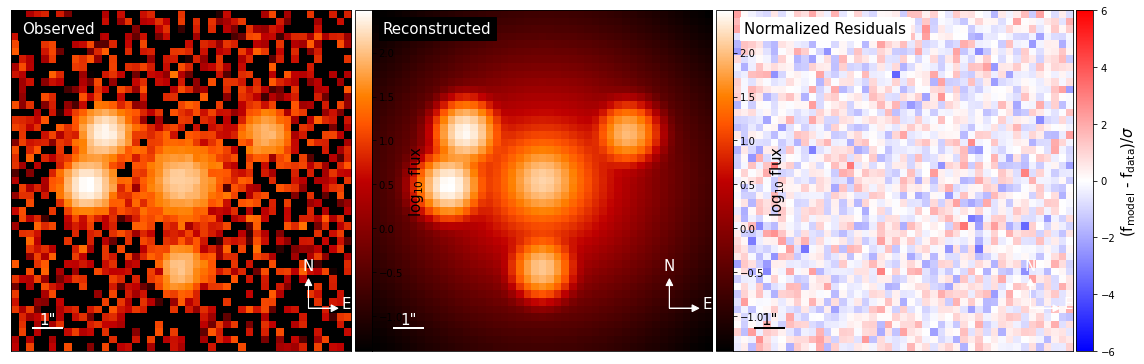

{'kwargs_lens': [{'theta_E': 3.1959040322951875, 'e1': -0.024996842094416657, 'e2': -0.030094064057101758, 'center_x': -0.0722477671033255, 'center_y': -0.0758898627980469}, {'gamma1': 0.02366780419294958, 'gamma2': 0.01949199323372644, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 457.346870927547, 'R_sersic': 0.9397261278789985, 'n_sersic': 2.2321349864486715, 'e1': 0.01766024463098336, 'e2': 0.005753553991323391, 'center_x': 0.017141158383967722, 'center_y': -0.024649427256870297}], 'kwargs_ps': [{'ra_image': array([ 2.97214469, -3.25306117, -2.65768756, -0.01821083]), 'dec_image': array([ 1.64599645, -0.16452794,  1.66636065, -3.05088837]), 'point_amp': array([1589.14285381, 5590.35919611, 4586.22877841, 1979.671384  ])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [140]:
# run model
model(kwargs_lens_initial, kwargs_lens_light_initial, kwargs_ps_initial)